In [ ]:
import qiskit 
print(qiskit.__version__)

### Knapsack

In [4]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# quantum imports
from qiskit_optimization.applications import Maxcut, Knapsack
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')


estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)

### Generate a Random Instance

In [5]:
# Parameters for the knapsack problem
num_items = 5
max_weight = 10

# Generate random weights and values for the items

weights = np.random.randint(1, 10, size=num_items)
values = np.random.randint(10, 50, size=num_items)

# Capacity of the knapsack
capacity = int(0.6 * np.sum(weights))

print(f"Weights: {weights}")
print(f"Values: {values}")
print(f"Capacity: {capacity}")

# Create the Knapsack problem
knapsack = Knapsack(values.tolist(), weights.tolist(), capacity)

# Convert the problem to a QuadraticProgram
problem = knapsack.to_quadratic_program()
print(problem.prettyprint())

Weights: [3 2 9 8 4]
Values: [19 24 11 43 16]
Capacity: 15
Problem name: Knapsack

Maximize
  19*x_0 + 24*x_1 + 11*x_2 + 43*x_3 + 16*x_4

Subject to
  Linear constraints (1)
    3*x_0 + 2*x_1 + 9*x_2 + 8*x_3 + 4*x_4 <= 15  'c0'

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



### Exact Solution

In [6]:
# Solve the problem using CplexOptimizer
optimizer = CplexOptimizer()
result = optimizer.solve(problem)

print("Solution:")
print(result.fval)
print(result.x)

Solution:
86.0
[1. 1. 0. 1. 0.]


In [7]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Minimize
 obj: - 10279 x_0 - 6864 x_1 - 30791 x_2 - 27403 x_3 - 13696 x_4
      - 3420 c0@int_slack@0 - 6840 c0@int_slack@1 - 13680 c0@int_slack@2
      - 27360 c0@int_slack@3 + [ 2052 x_0^2 + 2736 x_0*x_1 + 12312 x_0*x_2
      + 10944 x_0*x_3 + 5472 x_0*x_4 + 1368 x_0*c0@int_slack@0
      + 2736 x_0*c0@int_slack@1 + 5472 x_0*c0@int_slack@2
      + 10944 x_0*c0@int_slack@3 + 912 x_1^2 + 8208 x_1*x_2 + 7296 x_1*x_3
      + 3648 x_1*x_4 + 912 x_1*c0@int_slack@0 + 1824 x_1*c0@int_slack@1
      + 3648 x_1*c0@int_slack@2 + 7296 x_1*c0@int_slack@3 + 18468 x_2^2
      + 32832 x_2*x_3 + 16416 x_2*x_4 + 4104 x_2*c0@int_slack@0
      + 8208 x_2*c0@int_slack@1 + 16416 x_2*c0@int_slack@2
      + 32832 x_2*c0@int_slack@3 + 14592 x_3^2 + 14592 x_3*x_4
      + 3648 x_3*c0@int_slack@0 + 7296 x_3*c0@int_slack@1
      + 14592 x_3*c0@int_slack@2 + 29184 x_3*c0@int_slack@3 + 3648 x_4^2
      + 1824 x_4*c0@int_slack@0 

In [22]:
num_vars = qubo.get_num_vars()
print(f"Number of variables: {num_vars}")

Number of variables: 9


In [8]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 10773.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1871.5+0.j, -1242. +0.j, -5637.5+0.j, -4994.5+0.j, -2500. +0.j,
  -627. +0.j, -1254. +0.j, -2508. +0.j, -5016. +0.j,   342. +0.j,
  1539. +0.j,  1368. +0.j,   684. +0.j,   171. +0.j,   342. +0.j,
   684. +0.j,  1368. +0.j,  1026. +0.j,   912. +0.j,   456. +0.j,
   114. +0.j,   228. +0.j,   456. +0.j,   912. +0.j,  4104. +0.j,
  2052. +0.j,

### VQE

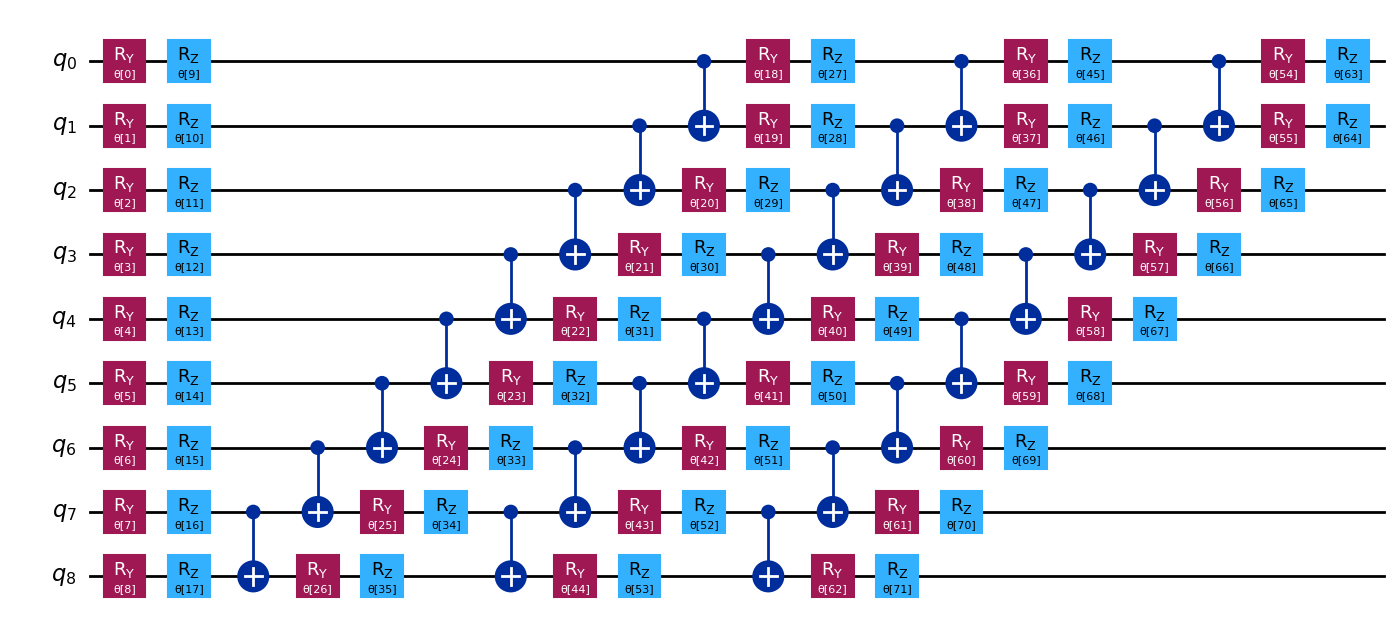

In [9]:
ansatz = EfficientSU2(qubitOp.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [10]:
num_params = ansatz.num_parameters
num_params

72

### Execute

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [12]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [13]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([3.13382625, 2.3120314 , 1.58761051, 2.41816623, 1.19612331,
       6.24578174, 2.75895241, 1.41061878, 6.17744077, 5.60292476,
       3.82991141, 4.88811952, 3.26875672, 5.79646918, 5.70620813,
       0.94988208, 0.14446434, 3.7634051 , 3.43520846, 2.84314489,
       1.17574808, 6.00928438, 3.49404184, 1.24416588, 5.71395323,
       2.5386517 , 2.1053223 , 4.63461029, 2.12232159, 3.36051331,
       5.46720439, 0.45521549, 0.80549654, 1.61795601, 4.8259057 ,
       5.80081057, 3.19373621, 0.59242116, 3.33648959, 3.37003002,
       0.903208  , 4.48115461, 2.36998998, 5.49301347, 3.34021078,
       4.56771876, 0.29034936, 3.11624688, 3.65345624, 1.86779639,
       2.47769017, 0.34660926, 0.31615588, 1.39439708, 3.07272229,
       3.08856714, 5.80981865, 1.7459151 , 5.47589864, 4.42834384,
       2.78420106, 2.84977079, 1.78995272, 1.99732325, 5.64303069,
       1.1238739 , 0.14236642, 5.64565204, 2.17034306, 2.23071647,
       3.95771793, 5.22177642])

In [14]:
ansatz = ansatz.decompose()

res = minimize(
        cost_func,
        x0,
        args=(ansatz, qubitOp, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: 1848.7548828125]
Iters. done: 2 [Current cost: 1994.5205078125]
Iters. done: 3 [Current cost: 2164.608642578125]
Iters. done: 4 [Current cost: 2748.7880859375]
Iters. done: 5 [Current cost: 1719.2431640625]
Iters. done: 6 [Current cost: 989.348388671875]
Iters. done: 7 [Current cost: 838.9462890625]
Iters. done: 8 [Current cost: 1689.7763671875]
Iters. done: 9 [Current cost: 187.908935546875]
Iters. done: 10 [Current cost: 996.84130859375]
Iters. done: 11 [Current cost: -398.194091796875]
Iters. done: 12 [Current cost: 116.503173828125]
Iters. done: 13 [Current cost: 292.587646484375]
Iters. done: 14 [Current cost: 144.5029296875]
Iters. done: 15 [Current cost: 34.12060546875]
Iters. done: 16 [Current cost: 221.527099609375]
Iters. done: 17 [Current cost: 735.012939453125]
Iters. done: 18 [Current cost: 1710.9404296875]
Iters. done: 19 [Current cost: 219.34375]
Iters. done: 20 [Current cost: 3033.9892578125]
Iters. done: 21 [Current cost: -120.604736328125

In [15]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -8471.4169921875
       x: [ 2.774e+00  2.905e+00 ...  4.004e+00  5.071e+00]
    nfev: 935
   maxcv: 0.0

### Post Processing

In [16]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [17]:
cost_history_dict["iters"] == res.nfev

True

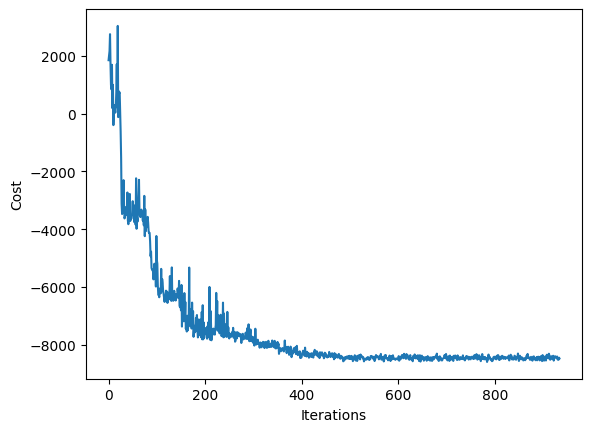

In [18]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

### Run the Optimized Params

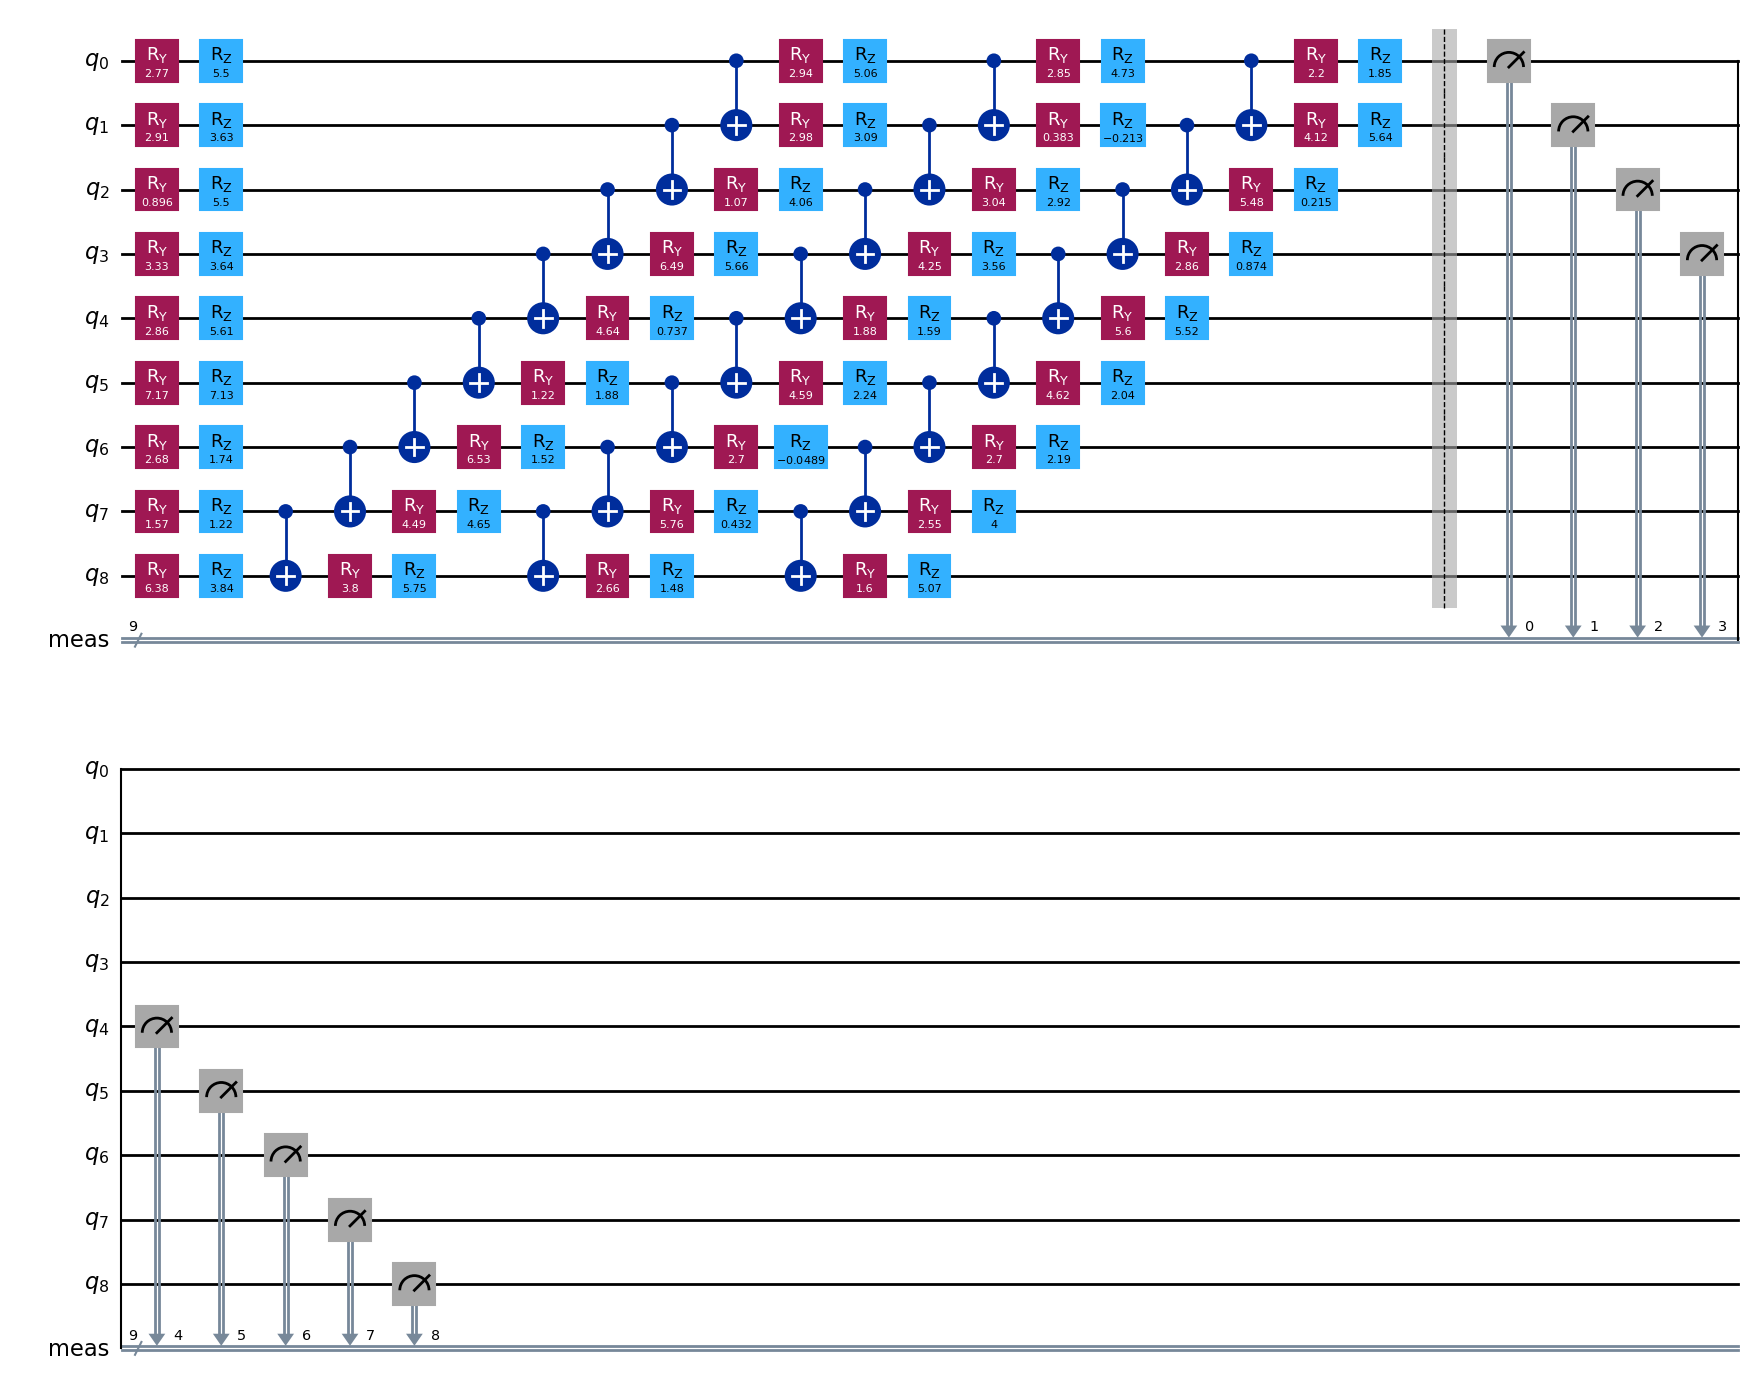

In [19]:
ansatz = ansatz.assign_parameters(res.x)
ansatz.measure_all()
ansatz.draw("mpl", style="iqp")

In [20]:
pub = (ansatz,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [44]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_vars)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 0, 1, 1, 0, 0]


In [45]:


# Find the indices of the top 4 values
top_4_indices = np.argsort(np.abs(values))[::-1][:4]
top_4_results = []
# Print the top 4 results with their probabilities
print("Top 4 Results:")
for idx in top_4_indices:
    bitstring = to_bitstring(keys[idx], num_vars)
    bitstring.reverse()
    top_4_results.append(bitstring)
    print(f"Bitstring: {bitstring}, Probability: {values[idx]:.6f}")


Top 4 Results:
Bitstring: [0, 1, 1, 0, 0, 1, 1, 0, 0], Probability: 0.072500
Bitstring: [0, 1, 0, 0, 1, 1, 1, 0, 0], Probability: 0.067600
Bitstring: [0, 1, 0, 1, 0, 1, 1, 0, 0], Probability: 0.064500
Bitstring: [0, 1, 0, 1, 0, 0, 1, 0, 0], Probability: 0.048700


In [46]:
print(top_4_results)

[[0, 1, 1, 0, 0, 1, 1, 0, 0], [0, 1, 0, 0, 1, 1, 1, 0, 0], [0, 1, 0, 1, 0, 1, 1, 0, 0], [0, 1, 0, 1, 0, 0, 1, 0, 0]]


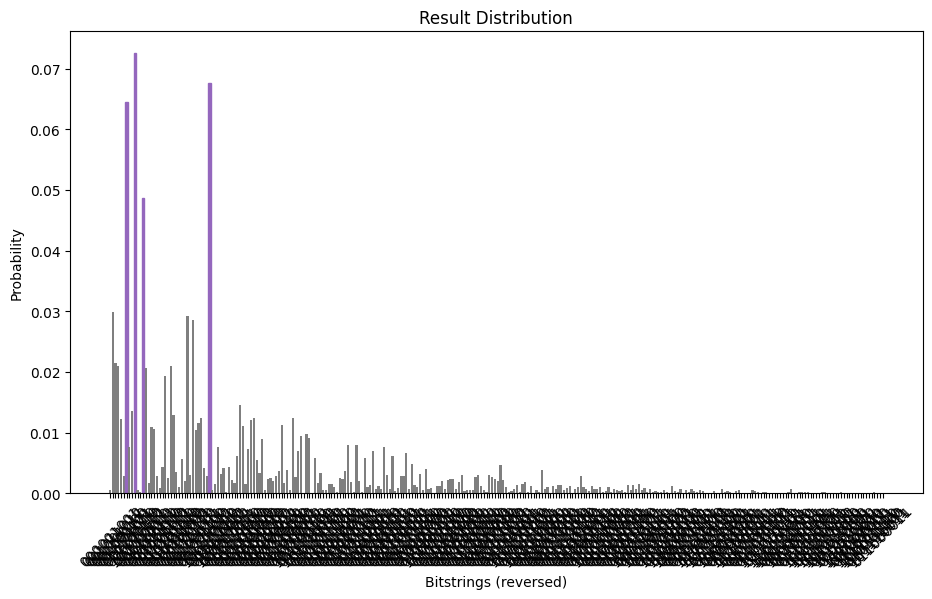

In [47]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin  # Assuming final_distribution_bin is defined elsewhere
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.extend(np.where(values == value)[0].tolist())  # Extract as a list to get individual elements

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")

# Ensure each position is an integer index for setting color
for p in positions:
    ax.get_children()[p].set_color("tab:purple")

plt.show()

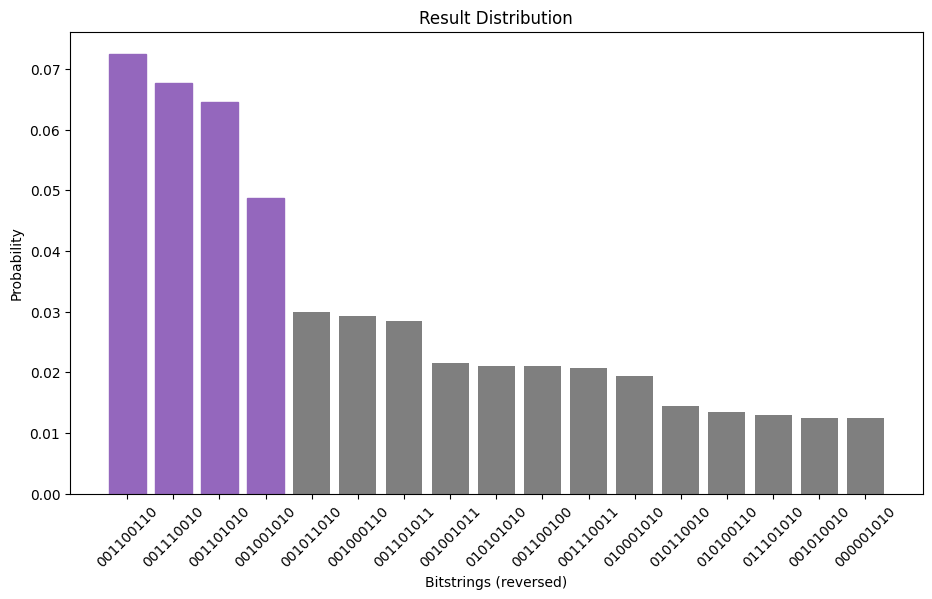

In [48]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Update matplotlib font size
matplotlib.rcParams.update({"font.size": 10})

# Assuming final_distribution_bin is defined elsewhere
final_bits = final_distribution_bin  

# Get the absolute values and sort to extract the top 16 and top 4 values
values = np.abs(list(final_bits.values()))
top_16_values = sorted(values, reverse=True)[:16]
top_4_values = sorted(values, reverse=True)[:4]

# Filter the top 16 bitstrings and their probabilities
top_16_bitstrings = []
top_16_probabilities = []

for bitstring, value in final_bits.items():
    if abs(value) in top_16_values:
        top_16_bitstrings.append(bitstring)
        top_16_probabilities.append(value)

# Sort the top 16 by probability for better visualization
sorted_indices = np.argsort(top_16_probabilities)[::-1]
top_16_bitstrings = [top_16_bitstrings[i] for i in sorted_indices]
top_16_probabilities = [top_16_probabilities[i] for i in sorted_indices]

# Plot the top 16 values
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(top_16_bitstrings, top_16_probabilities, color="tab:grey")

# Highlight the top 4 bars in purple
for i, bar in enumerate(bars):
    if top_16_probabilities[i] in top_4_values:
        bar.set_color("tab:purple")

plt.show()


### Convert QUBO solution to the problem solution

In [49]:
result = converter.interpret(most_likely_bitstring)
cost = problem.objective.evaluate(result)
feasible =problem.get_feasibility_info(result)[0]


print("Result knapsack:", result)
print("Result value:", cost)
print("Feasible:", feasible)

Result knapsack: [0. 1. 1. 0. 0.]
Result value: 35.0
Feasible: True


In [50]:
# Iterate through the list of bitstrings and evaluate for each
for bitstring in top_4_results:
    result = converter.interpret(bitstring)  # Interpret the bitstring
    cost = problem.objective.evaluate(result)  # Evaluate the cost for the bitstring
    feasible =problem.get_feasibility_info(result)[0]
    
    # Print the results
    print("Result knapsack:", result)
    print("Result value:", cost)
    print("Feasible solution:", feasible)


Result knapsack: [0. 1. 1. 0. 0.]
Result value: 35.0
Feasible solution: True
Result knapsack: [0. 1. 0. 0. 1.]
Result value: 40.0
Feasible solution: True
Result knapsack: [0. 1. 0. 1. 0.]
Result value: 67.0
Feasible solution: True
Result knapsack: [0. 1. 0. 1. 0.]
Result value: 67.0
Feasible solution: True
